У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NaiveSeasonal, NaiveDrift, XGBModel, ExponentialSmoothing, ARIMA, AutoARIMA, Prophet, RNNModel, \
  LightGBMModel
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.statistics import check_seasonality

from statsmodels.graphics.tsaplots import plot_pacf

# Set the style for mathplotlib
plt.style.use('ggplot')

In [2]:
raw_df = pd.read_csv('train.csv.zip')

raw_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
raw_df['date'] = pd.to_datetime(raw_df['date'])

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [4]:
raw_df.set_index('date', inplace=True)

Перевіряємо наш датафрейм

In [5]:
raw_df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [7]:
raw_df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



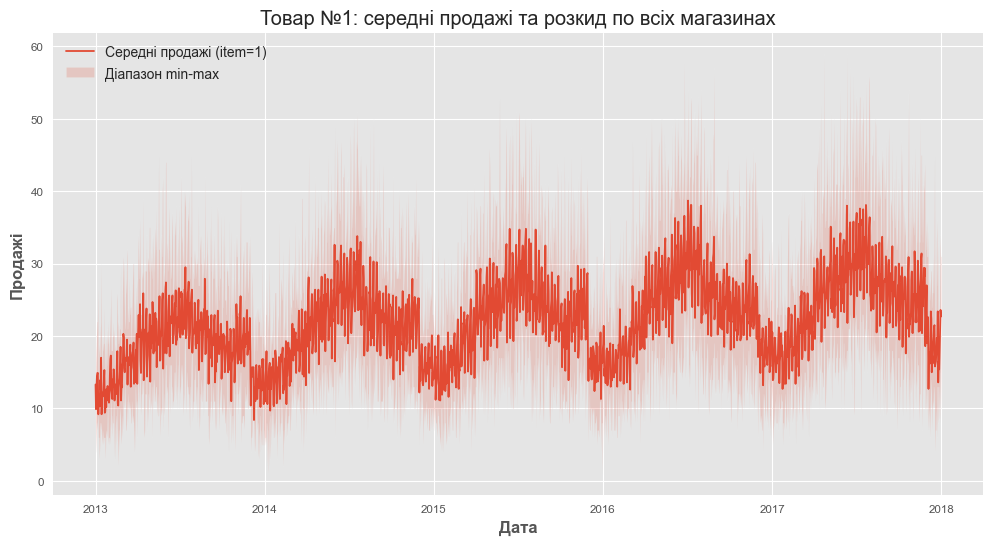

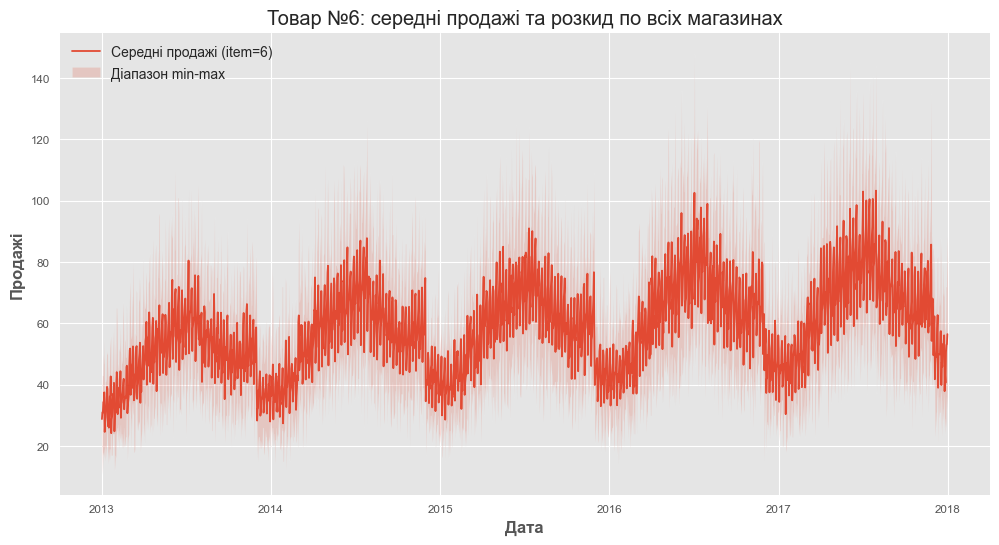

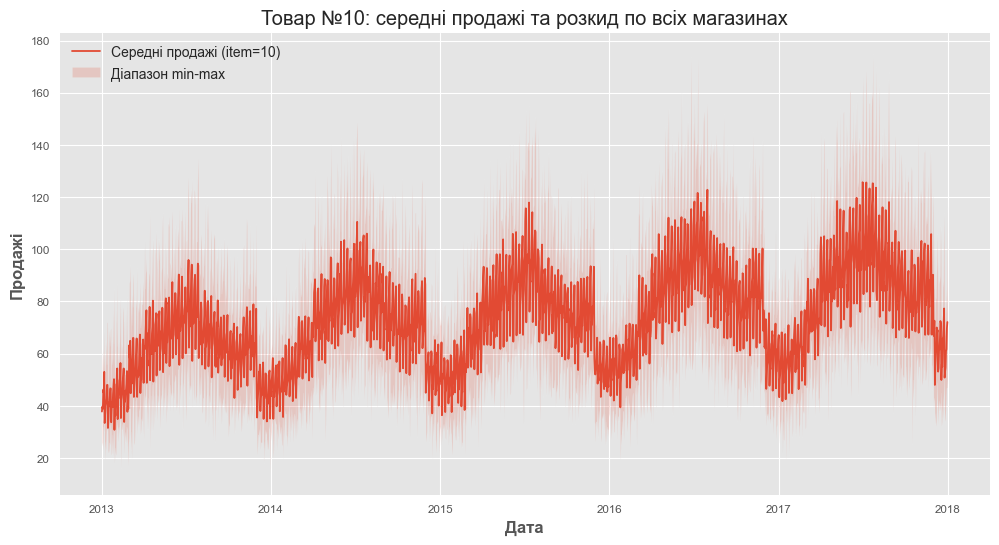

In [8]:
def plot_item_sales(item_id):
    item_df = raw_df[raw_df['item'] == item_id]

    item_agg = (
        item_df
        .groupby('date')['sales']
        .agg(['mean', 'min', 'max'])
        .reset_index()
    )

    plt.figure(figsize=(12,6))
    plt.plot(item_agg['date'], item_agg['mean'], label=f'Середні продажі (item={item_id})')
    plt.fill_between(item_agg['date'], item_agg['min'], item_agg['max'],
                      alpha=0.2, label='Діапазон min-max')
    plt.title(f"Товар №{item_id}: середні продажі та розкид по всіх магазинах")
    plt.xlabel("Дата")
    plt.ylabel("Продажі")
    plt.legend()
    plt.show()

plot_item_sales(1)
plot_item_sales(6)
plot_item_sales(10)

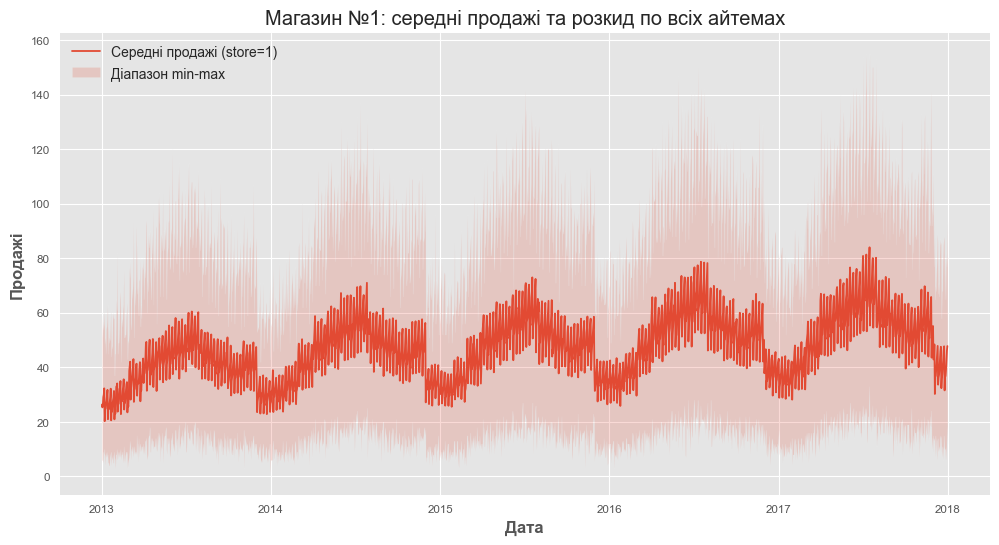

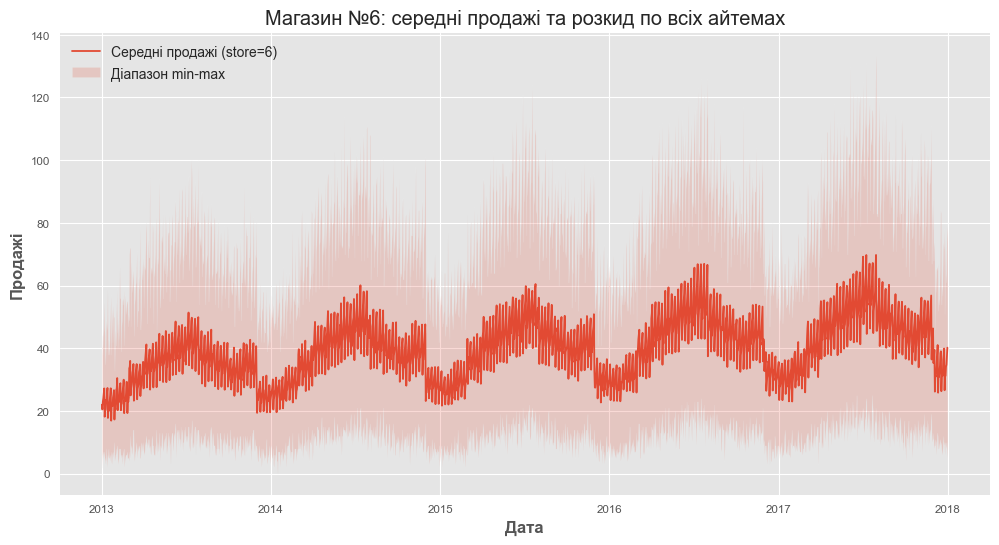

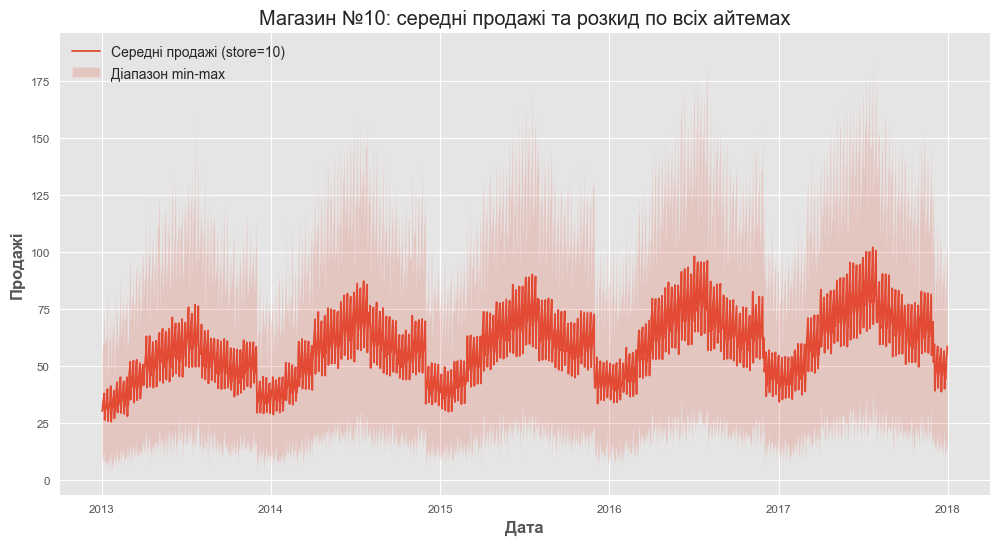

In [9]:
def plot_store_sales(store_id):
    store_df = raw_df[raw_df['store'] == store_id]
    store_agg = (
        store_df
        .groupby('date')['sales']
        .agg(['mean', 'min', 'max'])
        .reset_index()
    )
    plt.figure(figsize=(12,6))
    plt.plot(store_agg['date'], store_agg['mean'], label=f'Середні продажі (store={store_id})')
    plt.fill_between(store_agg['date'], store_agg['min'], store_agg['max'],
                      alpha=0.2, label='Діапазон min-max')
    plt.title(f"Магазин №{store_id}: середні продажі та розкид по всіх айтемах")
    plt.xlabel("Дата")
    plt.ylabel("Продажі")
    plt.legend()

plot_store_sales(1)
plot_store_sales(6)
plot_store_sales(10)

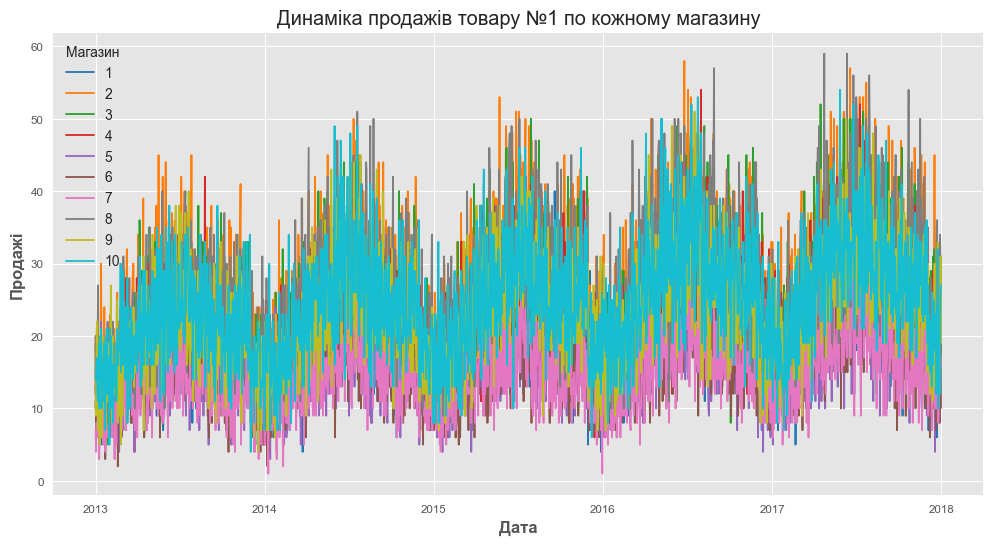

In [10]:
item1_df = raw_df[raw_df['item'] == 1]

plt.figure(figsize=(12,6))
sns.lineplot(data=item1_df, x='date', y='sales', hue='store', palette='tab10')
plt.title("Динаміка продажів товару №1 по кожному магазину")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.legend(title="Магазин")
plt.show()

**Висновок**:
1. Динаміка продажів по магазинах різна. В деяких магазинах продажі зростають, в інших - падають.
2. Чітко проглядається сезонність - влітку продажі зростають, а взимку падають.
3. Загальний тренд як на мене, то він позитивний.

Поки не знаю, що ще тут написати. Буду вдячний куратором за допомогу у відповідь на це ДЗ.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

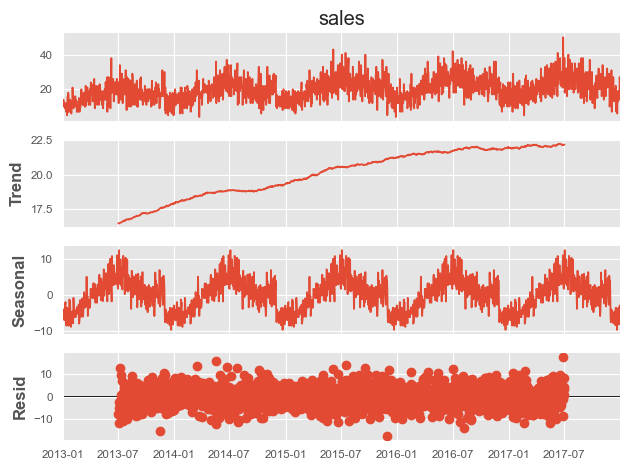

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

item1_store1_df = raw_df[(raw_df['item'] == 1) & (raw_df['store'] == 1)]

decomp = seasonal_decompose(item1_store1_df['sales'], model='additive', period=365)
decomp.plot()
plt.show()

**Висновок**:
1. Тренд дійсно зростаючий як і попередньо зазначалось. Хоч і на трішки, але зростає.
2. Сезонність проглядається. Попередньо вказав period=365, бо там взагалі графік сезонності виглядав як один закрашений графік.
3. Багато шумів, які не пояснюється видимо трендом та сезонністю, тому є шум в даних.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [12]:
item1_store1_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   store   1826 non-null   int64
 1   item    1826 non-null   int64
 2   sales   1826 non-null   int64
dtypes: int64(3)
memory usage: 57.1 KB


In [13]:
item1_store1_series = TimeSeries.from_dataframe(item1_store1_df, value_cols='sales', freq='D')

In [14]:
item1_store1_series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='date'>

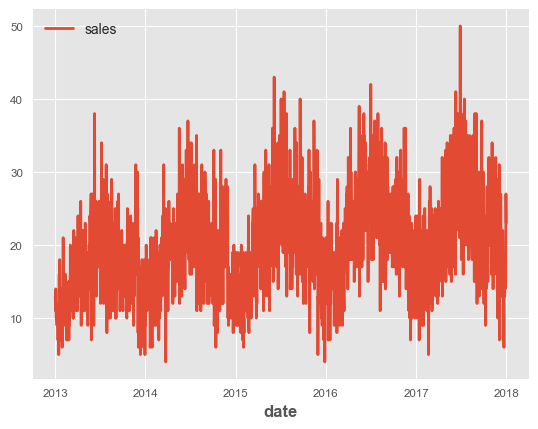

In [15]:
item1_store1_series.plot()

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

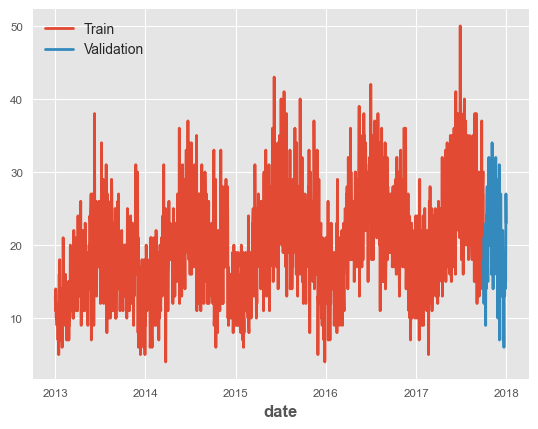

In [16]:
train_series, val_series = item1_store1_series.split_before(pd.Timestamp('2017-10-01'))
train_series.plot(label='Train')
val_series.plot(label='Validation')

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x600 with 0 Axes>

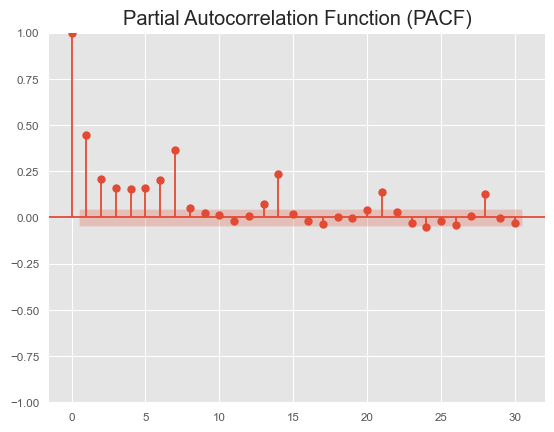

In [17]:
# Візуалізація часткової автокореляційної функції (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(item1_store1_series.pd_series(), lags=30, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**Висновок**:
Виглядає, що лаг 7, 14, 21, 28 мають суттєвий вплив на наші дані. Якщо так розібратись, що це кожні 7 днів (7, 14, 21, 28) і вони впливають на наші дані. Тобто точно тут бачимо тежневу сезонність.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [18]:
seasonality = check_seasonality(train_series, max_lag=30)


for m in range(2, 31):
    is_seasonal, period = check_seasonality(train_series, m=m, max_lag=30, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.
There is seasonality of order 28.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

<Axes: xlabel='date'>

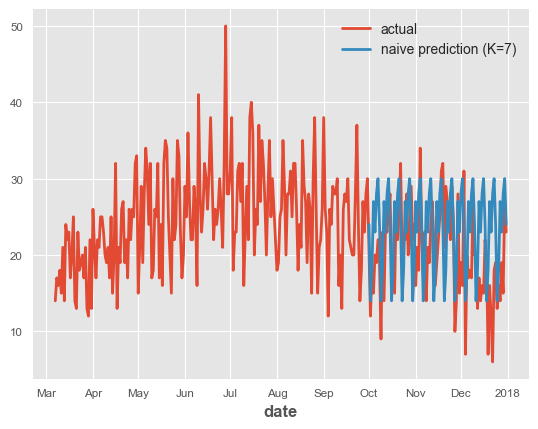

In [19]:
K = 7
naive_model = NaiveSeasonal(K=K)
naive_model.fit(train_series)
naive_pred = naive_model.predict(len(val_series))

item1_store1_series[-300:].plot(label="actual")
naive_pred.plot(label=f"naive prediction (K={K})")

<Axes: xlabel='date'>

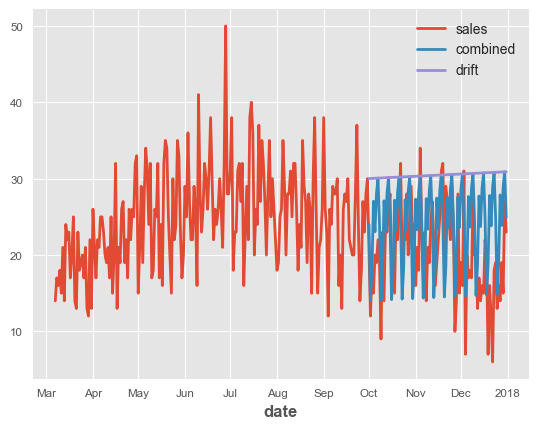

In [20]:
drift_model = NaiveDrift()
drift_model.fit(train_series)
drift_forecast = drift_model.predict(len(val_series))

combined_forecast = drift_forecast + naive_pred - train_series.last_value()

item1_store1_series[-300:].plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

**Висновок**
В цілому як на базову модель, то наче як ми і попадаємо, проте це ще не відображає дійсності модель і вона не уловлює цей патерн в даних. Будемо дивитись на помилку.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [21]:
naive_mape = mape(val_series, naive_pred)
print(f"Naive model MAPE: {naive_mape:.2f}%")

drift_mape = mape(val_series, combined_forecast)
print(f"Naive Drift model MAPE: {drift_mape:.2f}%")

Naive model MAPE: 38.17%
Naive Drift model MAPE: 39.91%


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [22]:
def enrich_with_date_features(df):
  df["quarter"] = df['date'].dt.quarter
  df["year"] = df['date'].dt.year
  df["month"] = df['date'].dt.month
  df["dayofyear"] = df['date'].dt.dayofyear
  df["dayofweek"] = df['date'].dt.dayofweek
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  return df

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

In [23]:
# Додавання ознак дати
train_transformed = enrich_with_date_features(train_series.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(val_series.pd_dataframe().reset_index())

# Convert back to TimeSeries
ts_train = TimeSeries.from_dataframe(train_transformed, time_col="date", value_cols=["sales"])
ts_val = TimeSeries.from_dataframe(val_transformed, time_col="date", value_cols=["sales"])

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(ts_train)
val_transformed = scaler.transform(ts_val)

In [24]:
def plot_results(series, forecast):
  # Візуалізація результатів
  series[-300:].plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 1727, number of used features: 7
[LightGBM] [Info] Start training from score 0.347625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed i

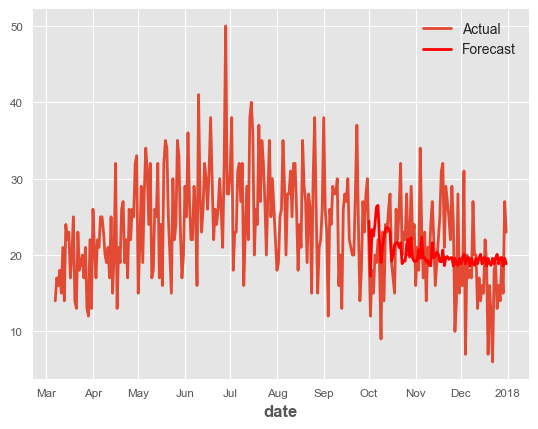

model LGBMRegressor(colsample_bytree=0.8, max_depth=3, n_estimators=200, n_jobs=-1,
              subsample=0.8) obtains MAPE: 27.80%


In [25]:
# Так як чомусь локально XGBoost не працює, то вибрав LightGBMModel

light_gbm_model = LightGBMModel(
    lags=7,
    output_chunk_length=1,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
)
light_gbm_model.fit(train_transformed)
pred = light_gbm_model.predict(len(val_transformed))

fit_and_plot(light_gbm_model, item1_store1_series, train_series, val_series)

**Висновок**:
Так як використав LightGBM замість XGBoost, то може результат і результат би був трохи краще проте навіть на зараз видно, що помилка біля 27%, що є вже набагато краще від наївних моделей і це ще ми не підбирали гіперпараметри. Тобто ця модель вже трохи краще уловлює складність часового ряду.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

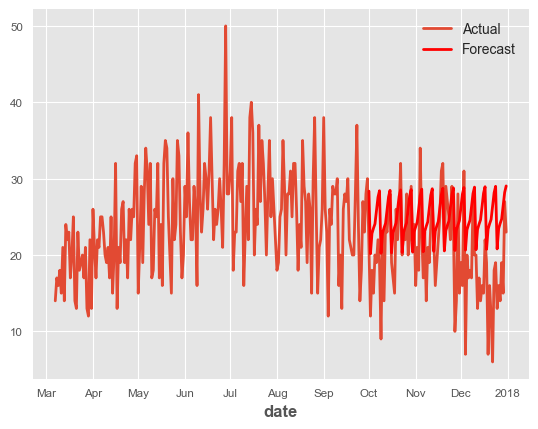

model ExponentialSmoothing() obtains MAPE: 38.94%


In [26]:
model = ExponentialSmoothing()
fit_and_plot(model, item1_store1_series, train_series, val_series)

**Висновок**
ExponentialSmoothing має гірший результат - аж 38.94% MAPE. Поки моделька не підходить дял вирішення завдання і LightGBM показує найкращий результат.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


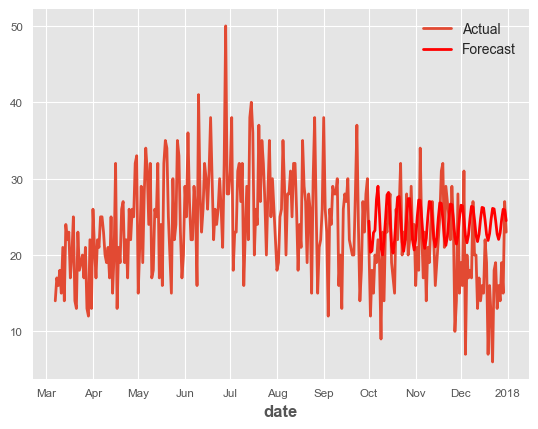

model ARIMA(q=3) obtains MAPE: 37.72%


In [27]:
model = ARIMA(p=12, d=1, q=3)

fit_and_plot(model, item1_store1_series, train_series, val_series)

**Висновок**:
В цілому непогано, якщо вказати параметри на рівні p=12, d=1, q=3. Помилка складає 37.72%. Можна спробувати покращили із AutoARIMA.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

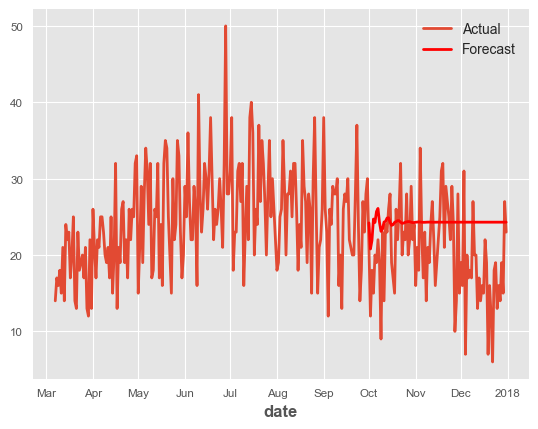

model AutoARIMA(start_p=1, max_p=20, start_q=1, max_q=5, n_jobs=-1) obtains MAPE: 39.53%


In [28]:
model = AutoARIMA(start_p=1, max_p=20, start_q=1, max_q=5, n_jobs=-1)
fit_and_plot(model, item1_store1_series, train_series, val_series)

In [29]:
model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Sat, 22 Mar 2025   AIC                          10591.078
Time:                        12:59:27   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.905      0.365      -0.040       0.109
ar.L2         -0.0798      0.034     -2.376      0.018      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.317      0.020      -0.143      -0.012
ar.L4         -0.0650      0.034     -1.936      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.064      0.287      -0.097       0.029
ar.L6          0.0063      0.030      0.209      0.834      -0.053       0.065
ar.L7          0.2638      0.029      9.044      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.258      0.000      -0.959      -0.855
sigma2        26.0958      0.820     31.811      0.000      24.488      27.704
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Висновок**:

Помилка на рівні 39%. Поки не вдалось знайти оптимальні параметри, які б покращували результат.

14. Натренуйте модель Prophet та зробіть висновок про її якість.

12:59:27 - cmdstanpy - INFO - Chain [1] start processing
12:59:27 - cmdstanpy - INFO - Chain [1] done processing
12:59:27 - cmdstanpy - INFO - Chain [1] start processing
12:59:27 - cmdstanpy - INFO - Chain [1] done processing


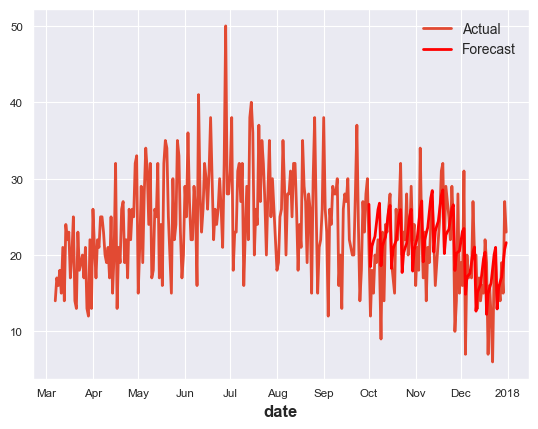

model Prophet() obtains MAPE: 23.81%


In [30]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(train_transformed)

# Прогнозування
forecast = model.predict(len(val_transformed))

fit_and_plot(model, item1_store1_series, train_series, val_series)

**Висновок**:

Із Prophet бачимо, що навіть із базовими налаштуваннями маємо 23.81% MAPE, що є набагато класніше ніж попередні усі базові моделі. Модель класно передбачає сезонність у даному випадку.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | criterion     | MSELoss          | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | rnn           | LSTM             | 2.8 K  | train
4 | V             | Linear           | 26     | train
-----------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | criterion     | MSELoss          | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | rnn           | LSTM             | 2.8 K  | train
4 | V             | Linear           | 26     | train
-----------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

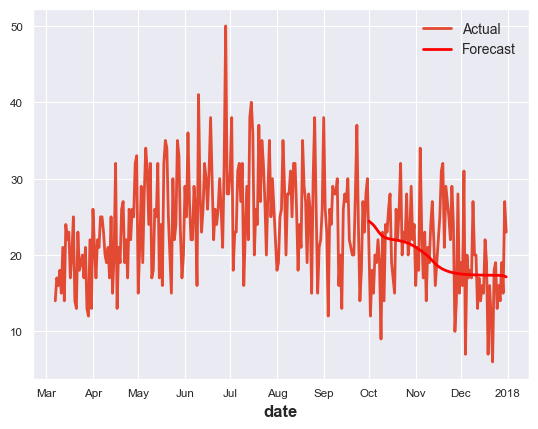

model RNNModel(model=LSTM, input_chunk_length=12, batch_size=64, pl_trainer_kwargs={'accelerator': 'cpu', 'strategy': 'auto', 'enable_progress_bar': True, 'max_time': '00:00:02:00'}) obtains MAPE: 27.07%


In [43]:
import os
from darts.models import RNNModel

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Побудова та тренування моделі LSTM
model = RNNModel(
    model='LSTM',
    input_chunk_length=12,
    batch_size=64,
    # https://github.com/unit8co/darts/issues/2477#issuecomment-2270574703
    pl_trainer_kwargs={
        "accelerator": "cpu",
        # "devices": [0],
        'strategy': 'auto',
        'enable_progress_bar': True,
        'max_time': "00:00:02:00"
    },
)
model.fit(train_transformed)

# Прогнозування
forecast = model.predict(len(val_transformed))

fit_and_plot(model, item1_store1_series, train_series, val_series)

**Висновок**:
Наразі MAPE 27.07%, що є гірше від Prophet моделі, проте це також гарний результат. По передбаченню можна побачити, що добре впізнає тренд)


16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

14:50:47 - cmdstanpy - INFO - Chain [1] start processing
14:50:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/12 [00:00<?, ?it/s]

14:50:48 - cmdstanpy - INFO - Chain [1] start processing
14:50:48 - cmdstanpy - INFO - Chain [1] done processing
14:50:48 - cmdstanpy - INFO - Chain [1] start processing
14:50:48 - cmdstanpy - INFO - Chain [1] done processing
14:50:48 - cmdstanpy - INFO - Chain [1] start processing
14:50:48 - cmdstanpy - INFO - Chain [1] done processing
14:50:48 - cmdstanpy - INFO - Chain [1] start processing
14:50:48 - cmdstanpy - INFO - Chain [1] done processing
14:50:48 - cmdstanpy - INFO - Chain [1] start processing
14:50:48 - cmdstanpy - INFO - Chain [1] done processing
14:50:48 - cmdstanpy - INFO - Chain [1] start processing
14:50:48 - cmdstanpy - INFO - Chain [1] done processing
14:50:48 - cmdstanpy - INFO - Chain [1] start processing
14:50:48 - cmdstanpy - INFO - Chain [1] done processing
14:50:48 - cmdstanpy - INFO - Chain [1] start processing
14:50:48 - cmdstanpy - INFO - Chain [1] done processing
14:50:48 - cmdstanpy - INFO - Chain [1] start processing
14:50:49 - cmdstanpy - INFO - Chain [1]

MAPE = 24.52%


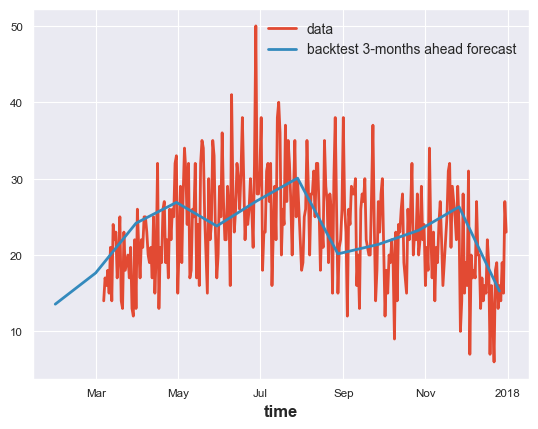

In [48]:
# В моєму випадку модель із Prophet виявилась кращою.

best_model = Prophet()
best_model.fit(train_transformed)

# Прогнозування
forecast = best_model.predict(len(val_transformed))


backtest_forecast = best_model.historical_forecasts(
    series=item1_store1_series,        # повний часовий ряд
    start=pd.Timestamp("2017-01-01"),  # з якої дати починати бектест
    forecast_horizon=30,          # на скільки днів вперед прогнозуємо щоразу
    stride=30,                    # крок між послідовними прогнозами (теж 30 днів)
    retrain=True,                 # чи перетреновувати модель на всій історії до кожної точки
    overlap_end=False,            # щоб прогнози не "перекривалися"
    last_points_only=True,        # якщо True – поверне лише останні точки кожного прогнозу
    verbose=True,
)

item1_store1_series[-300:].plot(label="data")
backtest_forecast.plot(label="backtest 3-months ahead forecast")
print(f"MAPE = {mape(item1_store1_series, backtest_forecast):.2f}%")

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Виглядає так, що Prophet добре справляється із цією задачею, тому використав би Prophet. На бектесті також добре показала. Можна було б окрему тренувати кожну модель під кожен товар в кожному магазині, щоб у кожного була своя модель. На перший погляд може показати, що багато моделей, але тут показало що на моїй локальній машині воно дуже швидко тренерується, тому можна було б спробувати в цей варіант піти із 10 * 50 = 500 моделей. Це буде більш точніши прогнози для кожного товару в кожному магазині, бо все ж є резідуали які впливають на продажі. Для того створив би загальну функцію, яка б приймала item_id та store_id для обчислення моделі і прогнозування. Оцінку би робили по MAPE як більш зрозуміли для оцінки моделей. Думаю там би воно коливалось у межах ~24% +- 2-4% для різних товарів.